## Partie : Prediction basée sur les densité de nuance de gris

## Importation des bibliothèques

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from skimage import io
import os
from sklearn.utils import shuffle

## Importation des données

In [1]:
format_fichier = [".jpg"]

def lire_images(cheminRacine, array, y, index):     
    for lists in os.listdir(cheminRacine): 
        chemin = os.path.join(cheminRacine, lists) 
        filename, extension = os.path.splitext(chemin) 
        if extension in format_fichier:   
            array.append(mpimg.imread(chemin))
            y.append(index)
        if os.path.isdir(chemin): 
            lire_images(chemin, array, y, index)
images = []
classes = []
lire_images("./Training/Banana", images, y,0)
lire_images("./Training/Corn", images, y,1)
lire_images("./Training/Strawberry", images, y,2)
lire_images("./Training/Raspberry", images, y,3)
lire_images("./Training/Clementine", images, y,4)
lire_images("./Training/Pear Williams", images, y,5)
lire_images("./Training/Nectarine", images, y,6)
lire_images("./Training/Orange", images, y,7)
lire_images("./Training/Lychee", images, y,8)
lire_images("./Training/Kiwi", images, y,9)
lire_images("./Training/Blueberry", images, y,10)
lire_images("./Training/Cherry 1", images, y,11)
lire_images("./Training/Apricot", images, y,12)
lire_images("./Training/Lemon", images, y,13)
lire_images("./Training/Watermelon", images, y,14)
lire_images("./Training/Tangelo", images, y,15)
lire_images("./Training/Plum", images, y,16)
lire_images("./Training/Peach", images, y,17)
lire_images("./Training/Kaki", images, y,18)
lire_images("./Training/Mango", images, y,19)


fruits = ["Banane","Mais","Fraise","Framboise","Clementine","Poire",
          "Nectarine","Orange","Lychee","Kiwi","Mirtille","Cerise",
          "Abricot","Citron","Melon","Tangelo","Plum","Peche","Kaki","Mangue"]

K = len(fruits)

images,classes = shuffle(images, classes, random_state=10) 

NameError: name 'y' is not defined

## Fonctions de préparation des données

In [3]:
def transformer_en_gris(img_orig):
    im = np.zeros((img_orig.shape[0],img_orig.shape[1])) # On fait une copie de l'original
    for i in range(img_orig.shape[0]):
        for j in range(img_orig.shape[1]):
            r, v, b = img_orig[i, j]
            moyenne = np.mean(img_orig[i, j])
            im[i, j] = int(moyenne)
    return im 

## Définition de l'hyper paramètre

[ 166 2295 2738 1778  112   88 2823]


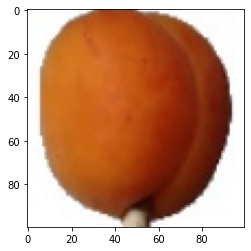

In [83]:
NBbins = 8 # HYPER PARAMETRE A DEFINIR
bins = np.linspace(0, 255, NBbins)

## Fonctions de preprocessing

In [148]:
def histoPerImage(image,nbBins):
    NBbins = nbBins
    bins = np.linspace(0, 255, NBbins)
    image = transformer_en_gris(image)
    densiteGris, bin_trash = np.histogram(image.ravel(),bins)
    return densiteGris#[:-1] # SUPPRIME TOUT LES PIXELS BLANC

In [152]:
def constructionXByHistogramme(images, nbBins): # /!\ nbBins >= 3 /!\ 
    X = np.zeros((np.shape(images)[0],nbBins - 1))
    for i in range (np.shape(images)[0]):
        histo = histoPerImage(images[i],nbBins)
        histo = np.array(histo, dtype = np.float)
        histo /= histo.max()
        mask = (histo > 0.01)
        histo[mask] = 1
        histo[np.invert(mask)] = 0
        X[i] = histo
    return X

In [153]:
X = constructionXByHistogramme(images,255)
y = np.array(classes)

In [154]:
Ntot   =  X.shape[0]
Ntrain = int(0.8 * Ntot)

X_train = X[:Ntrain]
X_test  = X[Ntrain:]
y_train = y[:Ntrain]
y_test  = y[Ntrain:]

print(y_train.shape)

(3862,)


## Modèle d'apprentissage : Le Bayésien Naïf

In [2]:
def BayesienNaif_fit(X,y):
    N = X.shape[0]
    D = X.shape[1]
    
    pkd = np.zeros((K,D))
    Pk = np.zeros((K,))
    
    for k in range(K):
        mask = (y == k)
        Pk[k] = np.sum(mask) / N
        
        Xk = X[mask]
        for d in range(D):
            count = 0
            for n in range(Xk.shape[0]):
                count += Xk[n , d]
            
            pkd[k , d] = count / Xk.shape[0]
    
    return pkd, Pk

## la fonction de dećision (a parametres fixés) ##
def BayesienNaif_predict(X,pkd, Pk):
    epsilon = 1e-8
    N = X.shape[0]
    D = X.shape[1]
    
    y_pred = np.zeros(N)
    
    for n in range(N):
        x = X[n]
        score = np.zeros(K)
        for k in range(K):
            score[k] = (
                np.log(Pk[k])
                +
                np.sum(
                x * np.log(pkd[k] + epsilon)
                    +
                (1 - x) * np.log(1 - pkd[k] + epsilon)
                )
            )
        k = np.argmax(score)
        y_pred[n] = k
    return y_pred

## Test du modèle

In [ ]:
## Affichage d'une image
plt.figure()
value=1 # fruit a tester
plt.imshow(X_test[n].reshape(50,50) , cm.gray)
plt.title("ceci est censé ressembler à un(e) "+str(fruits[y_test[n]])+" apres la binarisation")
plt.show()

In [ ]:
## Entrainement du modèle
pkd , Pk = BayesienNaif_fit(X_train, y_train)

## Résultat du modèle

In [155]:
ypred = BayesienNaif_predict(X_test, pkd,Pk)
print(f'valeur de l\'image : {y_test[value]} valeur predite : {ypred[value]}')
print("accuracy : ",np.sum(y_test == ypred) * 100 / X_test.shape[0],'%') 

valeur de l'image : 4 valeur predite : 4.0
accuracy :  89.02691511387164 %
